<h1 style="text-align:center;text-decoration: underline">Astronomy 350 Project #4</h1>

Prof. Quimby <br>
Spring 2025 <br>
**Due April 25 at 5pm**

## Background:

In 1923, Edwin Hubble discovered a [Cepheid variable star](https://ned.ipac.caltech.edu/level5/ESSAYS/Evans/evans.html) in the "Great Andromeda Nebula" (M31). It was known at the time that Cepheids had luminosities that closely correlated with the periods of their variability ([Leavitt & Pickering 1912](https://ui.adsabs.harvard.edu/abs/1912HarCi.173....1L/abstract) ). Using the observed magnitude of this object and the known period-luminosity relation for Cepheids, Hubble was able to [determine a distance](https://ui.adsabs.harvard.edu/?#abs/1925PA.....33..252H/abstract) to M31 and thus resolved the [Great Debate](https://apod.nasa.gov/diamond_jubilee/debate20.html) (spoiler alert: M31 is a separate galaxy!).

## Assignment:

Measure the distance to the Andromeda Galaxy (M31) using Palomar Transient Factory observations of Hubble's Cepheid Variable, V1.

# Resources:

- [NED "Level 5" essay on Cepheids](https://ned.ipac.caltech.edu/level5/ESSAYS/Evans/evans.html)
- [OGLE project Classical Cepheids page](http://ogle.astrouw.edu.pl/atlas/classical_Cepheids.html)
- [Paper](https://ui.adsabs.harvard.edu/abs/2016AJ....151...88B/abstract) on using Cepheids to measure galalxy distances


## Process

In [1]:
# some imports you may need
import os
import numpy as np
from glob import glob
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.time import Time
from astropy.stats import sigma_clip
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, aperture_photometry
from astropy.timeseries import LombScargle
from astropy.stats import bootstrap

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# silence warnings
import warnings
warnings.filterwarnings("ignore", module='astropy.wcs.wcs')

### Step1: Write a python function that returns a list of the M31-V1 image filenames

Images of M31-V1 can be downloaded from the [PTF image archive](https://irsa.ipac.caltech.edu/applications/ptf/), or you can use the image cutouts provided in the [M31-V1 repo](https://github.com/SDSU-astr350-2025-spring/M31-V1). There are 1457 images available. The files are stored as compressed FITS files, which is why the filenames end with `.fits.gz`. Fortunately, `astropy` can uncompress the files on the fly. 

In [14]:
!pwd

/home/jovyan/Midterms/project-04-rlabayog14


In [3]:
def get_filenames():
    """ return a list of strings giving the full path names to each FITS image """
    
    # location of the data directory
    datadir = '../../Midterm_Data/M31-V1' # change this to your actual directory path
    
    # suggestion: make use of glob, os.path.join, and the variable `datadir` defined above
    return glob(os.path.join(datadir, '*.fits.gz'))

In [4]:
# test your code
fnames = get_filenames()
len(fnames)

1457

Pick one good image and visually identify the target, which is located at 00h41m27.32s +41d10m10.7s.

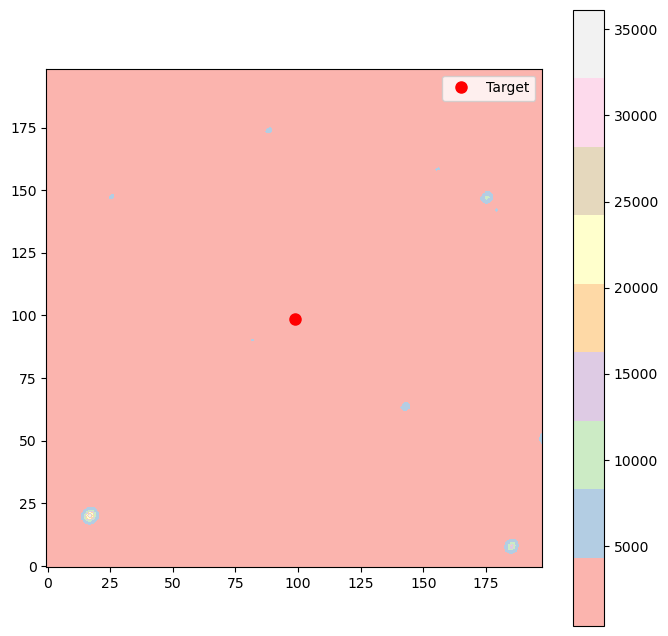

In [5]:
# show one of the images and identify the target
path = '../../Midterm_Data/M31-V1/PTF_201009055189_i_p_scie_t122713_u010907368_f02_p100043_c07_ra10.3638_dec41.1696_asec200.fits.gz'
data = fits.getdata(path)
header = fits.getheader(path)
wcs = WCS(header)

target = SkyCoord('00h41m27.32s', '+41d10m10.7s', frame='icrs')
x, y = wcs.world_to_pixel(target)


plt.figure(figsize=(8,8))
plt.imshow(data, cmap='Pastel1', origin='lower')
plt.plot(x,y, 'ro', markersize=8, label='Target')
plt.legend()
plt.colorbar()
plt.show()

<div class="alert alert-warning" role="alert">

**EA:** I can't see anything about the target in this image. You have some functions from earlier projects that you could use to show images!

</div>

### Step 2: Write a python function to load the positions of the target and comparison stars of known brightness. 

The brightness of the target on each image can be calculated relative to other, non-variable stars in the field with known magnitudes. The `m31.targets.txt` file in this repository holds the R.A., Dec., for the target in degrees and R-band magnitudes for five field stars near the target. These reference stars come from the work of [Massey et al. 2006](https://ui.adsabs.harvard.edu/abs/2006AJ....131.2478M/abstract). Complete the function template below to load these data into a numpy structured array.

In [14]:
# function template for you to complete
def load_objects():
    """ 
    return a numpy structured array with fields giving the 'name', 'ra',
    and 'dec', and 'Rmag' of the target and nearby comparison stars.
    """
    path = 'm31.targets.txt'
    data = np.genfromtxt(path, names = 'name, ra, dec, mag', dtype=None, encoding='utf-8')
    return data

In [15]:
# test your code 
objects = load_objects()
objects

array([('M31-V1', 10.3638333, 41.1696389,    nan),
       ('refstar1', 10.3575   , 41.1719167, 17.334),
       ('refstar2', 10.3624167, 41.17525  , 18.268),
       ('refstar3', 10.3710417, 41.1793333, 17.673),
       ('refstar4', 10.3801667, 41.1797222, 16.288),
       ('refstar5', 10.3810417, 41.1665833, 17.513)],
      dtype=[('name', '<U8'), ('ra', '<f8'), ('dec', '<f8'), ('mag', '<f8')])

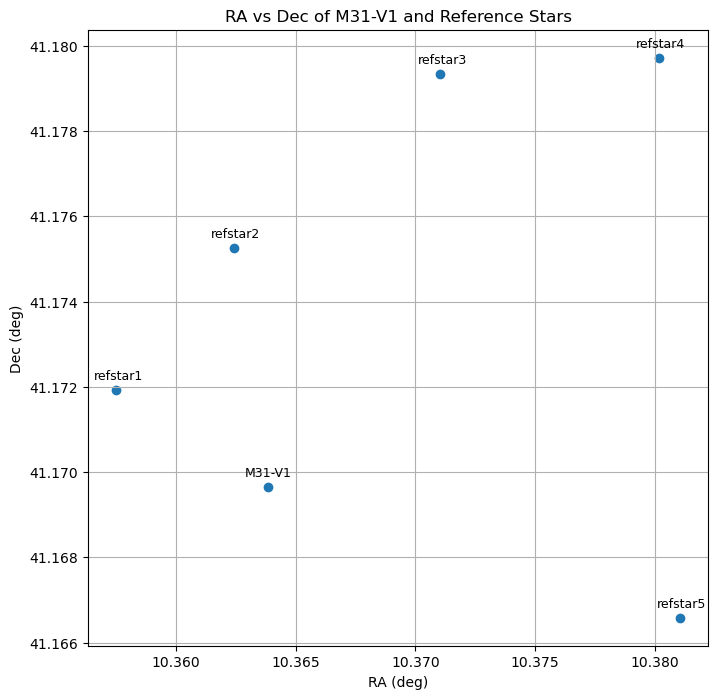

In [69]:
# make a plot showing the positions of the target and reference stars
m31 = objects['name'] == 'M31-V1'
plt.figure(figsize=(8,8))
plt.scatter(objects['ra'], objects['dec'])
for obj in objects:
    plt.text(obj['ra'] - 0.00095, obj['dec'] + 0.00025, obj['name'], fontsize=9)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('RA vs Dec of M31-V1 and Reference Stars')
plt.grid()
plt.show()
#plt.savefig('Raw_DecvsRA.pdf')

<div class="alert alert-warning" role="alert">

**EA:** You should have RA increase from right to left (standard north up, east left manner).

</div>

### Step 3: Write a python function to measure the background subtracted counts in a circular aperture at a given x, y location.

Complete the code template below.

In [70]:
def get_counts(image, xs, ys, radius):
    """
    Return the total (local background subtracted) counts and uncertainty in a circular aperture 
    
    `image` -- the 2D numpy array holding the counts recorded at each pixel
    `xs` -- an array of x-positions for the aperture centures
    `ys` -- an array of y-positions for the aperture centures
    `radius` -- radius (float) of the circular apertures in pixels
    """
    
    # make sure xs and ys are numpy arrays
    xs = np.atleast_1d(xs)
    ys = np.atleast_1d(ys)

    # size of the image
    ny, nx = image.shape
    
    # x, y coordinates for each pixel in the image
    imy, imx = np.indices(image.shape)
    
    # Start by creating an empty list to hold the measurements.
    # The loop below will add one row to this list at a time.
    # Each row will be a numpy structured array with columns named "counts" and "ecounts".
    # At the end, `measurements` will be converted from a list object to a numpy array.
    measurements = []
    dtype = [('counts', float), ('ecounts', float)]

    # determine the local background level for each position
    for x, y in zip(xs, ys):
        # make sure the aperture is fully contained on the image
        if (x < radius) | (y < radius) | (x > (nx-radius)) | (y > (ny-radius)):
            measurements.append( np.array( (np.nan, np.nan), dtype=dtype) )
            continue
        
        # define a circular aperture at this x, y
        aperture = CircularAperture((x,y), r=radius)

        # measure the counts in this aperture
        phot_table = aperture.do_photometry(image)
    
        # determine the distance from this x,y to each pixel in the image
        # hint: use imx and imy defined above
        dists = np.sqrt((imx - x)**2 + (imy - y)**2)

        # define a truth array, wbg, that is True only for image pixels 
        # from 4 * radius to 6 * radius from the target. This annulus
        # will be used to define the local background.
        wbg = (dists > 4*radius) & (dists < 6*radius)
        
        # find the local background values in the annulus
        bg_sample = image[wbg]
        
        # subtract the background contribution from the aperture sum (be careful!)
        bg_counts = bg_sample.mean()*aperture.area
        counts = phot_table[0][0] - bg_counts

        # get the uncertainty
        obj_var = np.abs(counts)
        bg_var = aperture.area * bg_sample.var()
        avbg_var = bg_sample.var() / bg_sample.size * aperture.area**2
        ecounts = np.sqrt( obj_var + bg_var +  avbg_var)

        # add this measurement
        measurements.append( np.array( (counts, ecounts), dtype=dtype) )
    measurements = np.array(measurements)
        
    return measurements['counts'], measurements['ecounts']


<div class="alert alert-warning" role="alert">

**EA:** Consider also using the `aperture_photometry()` function, which takes the aperture as an argument, instead of the `do_photometry()` method.

</div>

<div class="alert alert-warning" role="alert">

**EA:** Your `bg_sample` is not representative of the background since it may contain light from stars or other sources. You will need to use `sigma_clip`.

</div>

In [71]:
# test your code

# create a fake image with nothing but Poisson noise
n = 100
fake_image = np.random.poisson(400, size=(n, n))

# check what your get_counts function returns for a point near the center of the image.
# (as there are no objects in the fake image, the counts should be consistent with zero)
x = y = n / 2
get_counts(fake_image, x, y, 5)

(array([-14.13494857]), array([184.52200462]))

### Step 4: Determine the magnitude of the target on each image

For each image file, you will need to measure background subtracted counts for all reference stars, use these to determine the image zeropoint, $m_{zp}$, and thus the magnitude for the target, $m = m_{zp} - 2.5 \log({\rm counts})$. Complete the template below.

You will need to locate the x,y position of each object on each image. You can convert from (R.A., Dec.) to (x, y) and back using the WCS information in the image header. The [astropy.wcs](http://docs.astropy.org/en/stable/wcs/) module is very helpful for this!

In [72]:
# (inverse) gain of the PTF camera
GAIN = 2.13 # photoelectrons per count

def get_photometry():
    """
    return a numpy structured array with the date, magnitude, and magnitude uncertainty for
    the target and each of the reference stars.
    """
    
    # get the list of image files to work with
    fnames = get_filenames()

    # get the target and reference star positions
    objects = load_objects()
    
    # create a truth array to identify which of the objects are *not* M31-V1
    isrefstar = (objects['ra'] != 10.3638333) | (objects['dec'] != 41.1696389)
    
    # create a SkyCoord object to hold the R.A. and Dec. of all objects
    coords = SkyCoord(objects['ra'], objects['dec'], unit='deg')

    # Start by creating an empty array to hold the measurements.
    # The loop below will add data to this array.
    dtype = [('name', 'U20'), ('hjd', float), ('mag', float), ('emag', float)]
    data = np.array([], dtype=dtype)
    
    # loop over each file to measure the counts for the target and refstars
    for ifile, fname in enumerate(fnames):
        print(ifile, end="...")
        
        # load the header and image data
        image = fits.getdata(fname)
        head = fits.getheader(fname)

        # convert counts/pixel to photons/pixel
        image *= GAIN

        # get the heliocentric julian day from the header
        hjd = head['hjd']

        # we will do photometry in a 1*fwhm radius aperture, so
        # we need the fwhm from the header
        radius = head['fwhmsex']
        
        # get the wcs solution from the header
        wcs = WCS(head)

        # determine the x, y locations of the targets (including reference stars)
        xs, ys = wcs.world_to_pixel(coords)

        # get the object counts
        counts, ecounts = get_counts(image, xs, ys, radius)

        # require that all objects are well detected (S/N > 3) and on 
        # the image (get_counts will reture nan if the object is ouside the image)
        w = ~np.isfinite(counts)
        if w.sum() > 0:
            continue
        w = (counts / ecounts < 3)
        if w.sum() > 0:
            continue
        
        # determine zeropoint estimates from each *reference star*
        zps = objects['mag'][isrefstar] + 2.5*np.log(counts[isrefstar])

        # determine the best zeropoint for this image
        zp = np.median(zps)

        # calculate magnitudes for each object (including the reference stars)
        mags = zp - 2.5 * np.log10(counts)
        emags = 2.5 / np.log(10) * (ecounts/counts)
        
        # add these to the output data structure
        newdata = np.zeros(counts.size, dtype=dtype)
        newdata['name'] = objects['name']
        newdata['hjd'] = hjd
        newdata['mag'] = mags
        newdata['emag'] = emags
        data = np.append( data, newdata )
        
    return np.array(data)


<div class="alert alert-warning" role="alert">

**EA:** How come you hard-code in the coordinates of M31-V1 when defining `isrefstar`? Your `objects` array has all that information in there! (And, you can just isolate it by name, using `objects['name']`.)

</div>

<div class="alert alert-warning" role="alert">

**EA:** In `zps`, you use `np.log` (base $e$), which is not the same as `np.log10` (base 10) which is used for magnitudes.

</div>

In [20]:
# test your code
data = get_photometry()
print(data['name'])

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...119...120...121...122...123...124...125...126...127...128...129...130...131...132...133...134...135...136...137...138...139...140...141...142...143...144...145...146...147...148...149...150...151...152...153...154...155...156...157...158...159...160...161...162...163...164...165...166...167...168...169...170...171...172...173...174...175...176...177...178...179...180...181...182...183...184...

### Step 5: Plot the magnitudes vs. time (the light curves) for the target and reference stars

Recall that `data` will hold the magnitudes for the target and all of the reference stars, but you can access each of these separately using the `name` field. Verify that the reference stars are essentially constant in brightness over time while the target is variable.

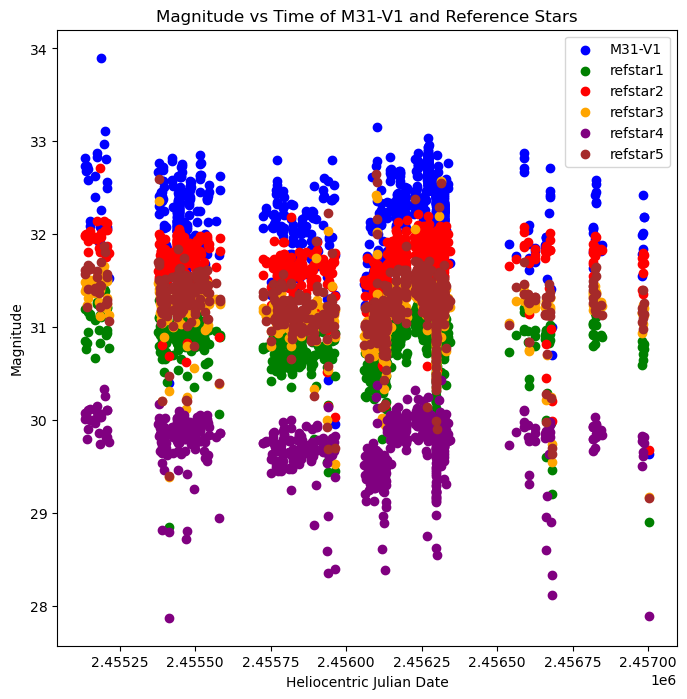

In [21]:
# plot the light curves
ref1 = data['name'] == 'refstar1'
ref2 = data['name'] == 'refstar2'
ref3 = data['name'] == 'refstar3'
ref4 = data['name'] == 'refstar4'
ref5 = data['name'] == 'refstar5'
m31 = data['name'] == 'M31-V1'


plt.figure(figsize=(8,8))
plt.scatter(data['hjd'][m31], data['mag'][m31], color = 'blue', label = 'M31-V1')
plt.scatter(data['hjd'][ref1], data['mag'][ref1], color = 'green', label = 'refstar1')
plt.scatter(data['hjd'][ref2], data['mag'][ref2], color = 'red', label = 'refstar2')
plt.scatter(data['hjd'][ref3], data['mag'][ref3], color = 'orange', label = 'refstar3')
plt.scatter(data['hjd'][ref4], data['mag'][ref4], color = 'purple', label = 'refstar4')
plt.scatter(data['hjd'][ref5], data['mag'][ref5], color = 'brown', label = 'refstar5')
plt.xlabel('Heliocentric Julian Date')
plt.ylabel('Magnitude')
plt.title('Magnitude vs Time of M31-V1 and Reference Stars')
plt.legend()
#plt.grid()
plt.show()
#plt.savefig('MvT.pdf')



<div class="alert alert-warning" role="alert">

**EA:** Errorbars? And, since a lower magnitude means a brighter object, you should invert that axis. Additionally, you write a bunch of very similar lines of code for this plot, you should consider making a function or loop to do so!

</div>

<div class="alert alert-warning" role="alert">

**EA:** The fact that your reference stars are variable when they should not be is a sign something has gone wrong in your photometry. Additionally, all your magntiudes are too low (consider: even Gaia's limiting magnitude is ~21).

</div>

### Step 6: Determine the period of the target

As you will note from the plot above, there is significant scatter in the target magnitudes. Inspecting the target light curve carefully you will find that most of the variability is periodic. Complete the function template below to determine the period of the target. 

Once you have found the period, plot the "phase-folded" light curve to see how the target brightens and fades with phase.

In [22]:
# extract the target light curve from the data structure
w = data['name'] == 'M31-V1'
lc = data[w]

In [23]:
def find_period(lc):
    """
    returns the best period (float) of the light curve (lc)
    
    `lc` is a numpy structured array with the observation epoch, magnitude, and magnitude uncertainty
    """
    
    frequency, power = LombScargle(lc['hjd'], lc['mag'], lc['emag']).autopower()
    period = 1 / frequency[np.argmax(power)]
    
    return period


<div class="alert alert-warning" role="alert">

**EA:** The number of samples per peak when using `autopower()` is 5, which is too low. You should change it to a much higher number, like 1000.

</div>

In [24]:
# determine the period of the target
period = find_period(lc)
period

31.480481787521896

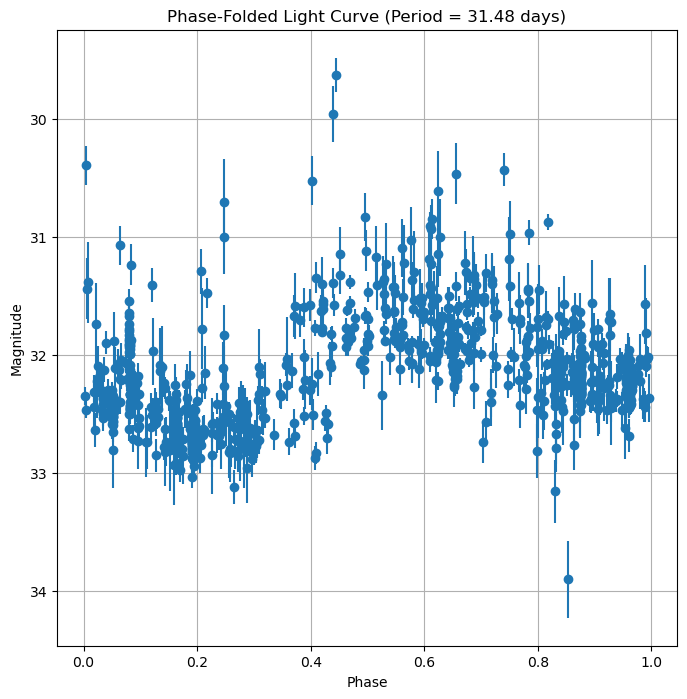

In [25]:
# plot the light curve as a function of phase
phase = (lc['hjd'] % period) / period

plt.figure(figsize = (8,8))
plt.errorbar(phase, lc['mag'], yerr=lc['emag'], fmt='o')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('Magnitude')
plt.title(f'Phase-Folded Light Curve (Period = {period:.2f} days)')
plt.grid()
#plt.show()
plt.savefig('phase.pdf')

### Step 7: Use the known Period-Luminosity Relation (PLR) to estimate the distance to M31

[Leavitt & Pickering 1912](http://adsabs.harvard.edu/abs/1912HarCi.173....1L) showed that the apparent brightness of Cepheid stars in the Small Magellanic Cloud (SMC) was strongly correlated with the period of the temporal variations. Since the SMC is much further away from us than its stars are from each other, the stars can be considered to all be at the same distance, so essentially the periods are correlated with luminosity.

More recent measurements by [OGLE](http://ogle.astrouw.edu.pl/atlas/index.html) (and others) have precisely measured this relation, which can be expressed as:

$$ M = a \log_{10}(P) + b$$

where $M$ is the absolute magnitude (at median brightness), $P$ is the period in days, and $a$ and $b$ are constants. It is common to measure the brightness of the stars in the $V$ or $I$ bands, but not the $R$ band due to contamination from H$\alpha$. But we have $R$ band data, so we will simply estimate the $a$ and $b$ constants from the average of the $V$ and $I$ band relations. Using the results of [Udalski et al. 1999](http://adsabs.harvard.edu/abs/1999AcA....49..201U), we can then estimate $a = -2.86$ and $b = -1.42$ in the $R$ band.

Given the period you found in **Part 7** and the median apparent magnitude of the target from **Part 5**, estimate the distance to M31 in Mpc.

In [33]:
# predict the absolute magnitude (at median brightness) from the period
a = -2.86
b = -1.42
M = a * np.log10(period) + b

In [60]:
# calculate the distance in Mpc
mag_med = np.median(data['mag'][m31])

dist = 10 ** ((mag_med - M + 5) / 5 / 1e6) 
print(f'{dist:.5f}')

1.00002


<div class="alert alert-warning" role="alert">

**EA:** To convert to Mpc, you divide by 1e6 outside the parentheses, not inside.

</div>

### Step 8: Estimate the uncertainty in your distance measurement 

To calculate the uncertainty in the target's absolute magnitude (see equation above), you need the uncertainties $\sigma_a$ and $\sigma_b$ for the parameters $a$ and $b$, respectively. Lets assume these are $\sigma_a = 0.025$ and $\sigma_b = 0.018$ (again, these are estimated based on the $V$ and $I$ results from [Udalski et al. 1999](http://adsabs.harvard.edu/abs/1999AcA....49..201U). Additionally, you need the uncertainty in the period, $P$. To estimate this, you can use the bootstrap or jackknife techniques described in [Hogg, Bovy, and Lang 2010](https://arxiv.org/abs/1008.4686) (see their section 4). However, you should find that the period is well determined and contributes negligibly to the overall error. Thus, **estimation of the period uncertainty is optional**. 

In [ ]:
# bootstrap to find the uncertainty in the Period [optional]


In [64]:
# absolute magnitude uncertainty
sigma_a = 0.025
sigma_b = 0.018
sigma_P = 0.01 # rough estimate; substitute your value from above if bootstrapping
sigma_M = np.sqrt((np.log10(period)*sigma_a)**2 + sigma_b**2 + (a / (period * np.log(10)) * sigma_P)**2)
print(f'{sigma_M:.3f}')

0.042


Use uncertainty propagation to provide the formal uncertainty in the distance. Note that you can also bootstrap to find the uncertainty in the target's median brightness, but, similar to the period uncertainty, will be small and can be ignored. 

In [68]:
# calculate the distance uncertainty
sigma_D = (np.log(10) / 5) * dist * sigma_M
print(f'{sigma_D:.3f}')

0.019


### Step 9: Write up your results

Present your results in a ApJ style paper using $\LaTeX$. Your paper should demonstrate your mastery of photometry and provide clear discussion of how you measured the distance to M31.

Include figures and citations properly referenced in the text. Sections of the paper should include:
   * *Abstract*: a concise statement of the paper's objective, key methods, main results, and impact.
   * *Introduction*: provide background information on the material covered in the paper. This section typically begins with motivation for the current work (e.g. "it is important to know X because Y, but it is hard to know X because..."). Introductions should also give the reader a guide of what is to come in later sections.
   * *Data*: explain where the data used in the paper come from and specifically point out anything about the data that may affect the precision or accuracy of the results.
   * *Analysis*: this is where you take the available data, apply the techniques discussed in the introduction, and produce new measurements. Explain how you get from the data to the measurements.
   * *Discussion/Conclusions*: what are the implications of the Analysis? Summary of what has been learned. What are the limitations of the results? What could be done to improve the results?

Additionally, the paper should have a title, list the authors who contributed, and provide references.

<div class="alert alert-warning" role="alert">

**Notebook**
<ul>
<li> Loading Data 5/5
<li> Photometry 13/15
<li> Plots 9/10
<li> Period finding 9/10
<li> Distance and uncertainty 9/10
</ul>

**Report**
<ul>
<li> Title, Abstract, Latex 13/15
<li> Introduction 8/10
<li> Data 3/5
<li> Analysis 11/15
<li> Conclusions 3/5
</ul>


</div>


In [25]:
5 + 13 + 9 + 9 + 9 + 13 + 8 + 3 + 11 + 3

83